In this homework assignment we use multinomial logistic regression models to predict one of $K$ discrete classes.  The class labels are $y_{nk}$ and the features for the $n$ sample are $\phi_{n} \in \mathbb{R}^D$.  The multinomial logistic regression model is then,
$$
p ( y_{nk} = 1 | \phi_n, w) = \frac{ \exp ( w_k^T \phi_n ) }{ \sum_{l = 1}^K \exp ( w_l^T \phi_n ) }
$$
where the weights vectors for each of the $k$ classes are $w_k \in \mathbb{R}^D$.  The weight vectors are assigned a prior in which each entry is a centered Gaussian with variance $\alpha$.  

The MAP estimate for $w$ is then the minimizer of the objective function
$$
f (w) = \frac{ \alpha}{2} ||w||_2^2 - \sum_n \left[ \sum_k y_{nk} w_k^T \phi_n - \log \left( \sum_l \exp ( w_l^T \phi_n\right) \right],
$$
which is up to constants, the negative log conditional likelihood of $w$, $p ( w | \phi, y)$.

<b>Problem 1</b>. For the gamma ray data from the previous problem set, implement a logistic regression classifier.  The gamma ray data has features $x_n \in \mathbb{R}^D$, for $D=10$.  Based on the data vectors $x_n$, generate the following three different sets of feature vectors for validation purposes:
1. $D$ linear features, $\phi_{nd} = x_{nd}$ and a linear bias term $\phi_{n (D+1)} = 1$.
2. In addition to the $D+1$ features above, an additional $D$ diagonal quadratic terms, $x_{nd}^2$.
3. In addition to the $2D+1$ features above, the off-diagonal quadratic features $x_{nd} x_{nd'}$ for $d \neq d'$.

For each of the three sets of features above, do the following for a range of $\alpha \in \{ 10^{-8}, 10^{-7}, \dots , 10^{1} \}$. 

<b>1a)</b> Plot the negative log conditional likelihood of the train data as a function of $\alpha$, as well as the accuracy of the classifier on the train data.

In [18]:
import numpy as np
import hw5
import imp
imp.reload(hw5)
from scipy.io import loadmat
data = loadmat('gamma2.mat')
keys = list(data.keys())[3:9]
alphas = np.power(10.0, np.arange(-8, 2))
results = {}
loadFit = False
#The following loops train the classifier for each of the three sets of features and all 10 of the regularizations.
#Make take a few minutes to run.
for method in range(3):
    results['classifier'+str(method)] = hw5.logisticRegression(k=2)
    results['classifier'+str(method)].loadData(data, keys)
    results['classifier'+str(method)].makeFeatures(method)
    if loadFit:
        weights =np.load('jan'+str(method)+'.npy')
    for i in range(10):
        if loadFit:
            ww = weights[i, :]
            obj = results['classifier'+str(method)].objective(ww,results['classifier'+str(method)].xTrain, results['classifier'+str(method)].yTrain, alphas[i], 2)
            results['minimization'+str(method)+'.'+str(i)] = hw5.optR(ww, obj)
        else:    
            results['classifier'+str(method)].fit(alphas[i])
            results['minimization'+str(method)+'.'+str(i)] = results['classifier'+str(method)].optimizationResult

In [19]:
parameters = {}
saveFit = False
#We save the result of the training to a file in order to save time.
for method in range(3):
    ww = np.zeros((10, results['classifier'+str(method)].w.shape[0]))
    for i in range(10):
        ww[i, :] = results['minimization'+str(method)+'.'+str(i)].x
    if saveFit:
        np.save('jan'+str(method), ww)

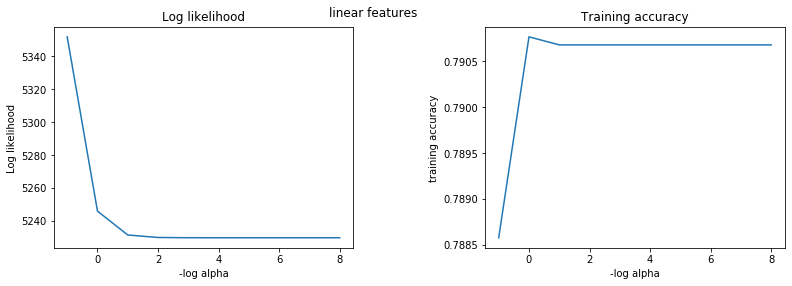

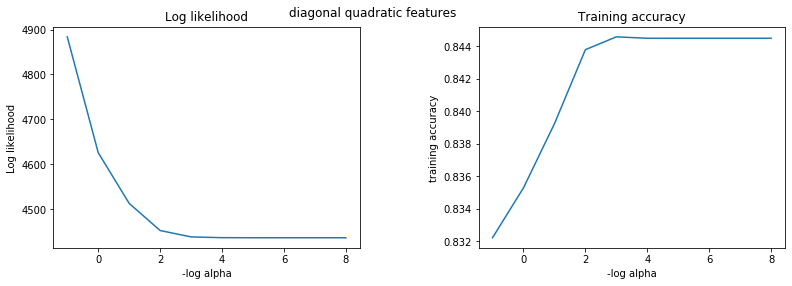

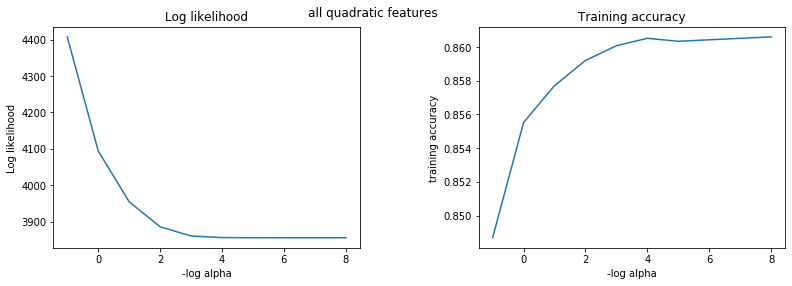

In [41]:
imp.reload(hw5)
featType = {}
featType['0'], featType['1'], featType['2'] = 'linear', 'diagonal quadratic', 'all quadratic'
for method in range(3):
    hw5.validationPlot([results['minimization'+str(method)+'.'+str(i)] for i in range(10)], results['classifier'+str(method)], np.arange(-8, 2), featType[str(method)]+' features')

<b>1b)</b> Plot the negative conditional log likelihood of the development data as a function of $\alpha$.  Find the $\alpha$ that minimizes this.

The alpha minimizing the log-likelihood of the development data for linear features is: 10^ -8
The alpha minimizing the log-likelihood of the development data for diagonal quadratic features is: 10^ -7
The alpha minimizing the log-likelihood of the development data for all quadratic features is: 10^ -7


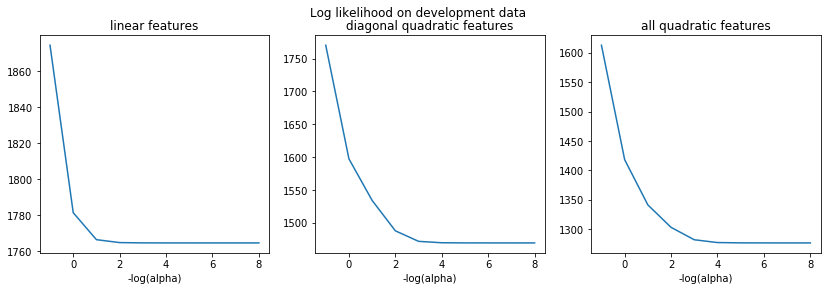

In [53]:
import matplotlib.pyplot as plt
best = np.zeros((3, ))+99
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(14)
fig.suptitle('Log likelihood on development data')
for method in range(3):
    devLL = [hw5.logisticRegression.objective(results['minimization'+str(method)+'.' + str(i)].x, results['classifier'+str(method)].xDev,results['classifier'+str(method)].yDev, alphas[i], 2) for i in range(10)]
    best[method] = np.argmin(devLL)
    ax[method].plot(-np.arange(-8, 2), devLL)
    ax[method].set_xlabel('-log(alpha)')
    ax[method].set_title(featType[str(method)]+' features')
    print('The alpha minimizing the log-likelihood of the development data for ' + featType[str(method)] + ' features is: 10^', np.arange(-8, 2)[int(best[method])])
plt.show()

<b>1c)</b> For each of the three feature sets, report the test accuracy of the classifiers minimizing the negative log likelihood of the development data.

In [54]:
for method in range(3):
    w = np.reshape(results['minimization'+str(method)+'.'+str(int(best[method]))].x, (2, -1))
    x = results['classifier'+str(method)].xTest
    y = results['classifier'+str(method)].testLabels.flatten()
    p = np.argmax(np.matmul(x, w.transpose()), axis=1)+1
    acc = np.sum(p.flatten() == y) / len(y)
    print('Test accuracy of classifier with lowest development log likelihood and '+featType[str(method)] +' features: '+'{:.4f}'.format(acc))

Test accuracy of classifier with lowest development log likelihood and linear features: 0.7973
Test accuracy of classifier with lowest development log likelihood and diagonal quadratic features: 0.8512
Test accuracy of classifier with lowest development log likelihood and all quadratic features: 0.8720


<b> Problem 2. </b> In this problem we compare logistic and linear regression for classification.  There are three toy data sets, each of which has two continuous features and is labelled one of either $K=2$ or $K=3$ classes.

Encoding the classes as row vectors $y_{nk} =1$ iff sample $n$ is in class $k$ allows us to reuse the linear regression code from homework 4 to fit $K$ linear regression models $\hat{w}_k$ to the data and predicting the class of the $n$ sample as
$$
\hat{y}_n = \mathrm{arg max}_k \phi^T_n \hat{w}_k
$$


<b>2.a)</b> The first data set contains two classes which lie in well-separated clouds. Fit the least squares linear regression classifier as above - if implemented correctly, the test accuracy should be 100%.  Is this the case? Plot the decision boundary.

The test accuracy is: 1.0


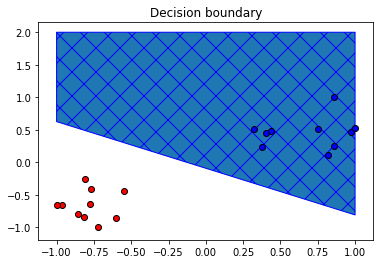

In [50]:
import hw4
import hw5
imp.reload(hw5)
import numpy as np
from scipy.io import loadmat
dataA = loadmat('partA_two_clouds.mat')
linA = hw4.linReg()
linA.loadData(dataA, list(dataA.keys())[3:7])
linA.fit()
linA.makePhi()
yHat = np.argmax(linA.phiTest.dot( linA.w), axis=1)
y = np.argmax(linA.yTest, axis=1)
print('The test accuracy is:', np.sum(y == yHat) / len(y))
plt.title('Decision boundary')
hw5.plotDecision(linA.w, linA.xTest, linA.yTest)

<b>2b)</b> The second dataset contains three classes with means arranged in a triangular pattern.  Train a least squares classifier as well as a multinomial logistic regression classifier using the same features.  Report test accuracy of both classifiers.

The test accuracy of linear regression is: 1.0


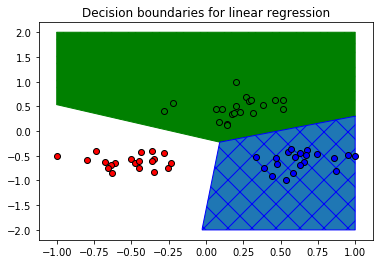

The test accuracy of logistic regression is: 1.0


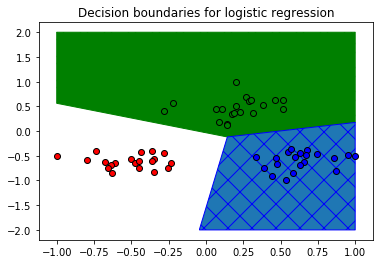

In [51]:
imp.reload(hw5)
import matplotlib.pyplot as plt
dataB = loadmat('partB_three_triangle.mat')
linB = hw4.linReg()
linB.loadData(dataB, list(dataB.keys())[3:7])
linB.fit()
linB.makePhi()
yHat = np.argmax(linB.phiTest.dot(linB.w), axis=1)
y = np.argmax(linB.yTest, axis=1)
print('The test accuracy of linear regression is:', np.sum(y == yHat) / len(y))

plt.title('Decision boundaries for linear regression')
hw5.plotDecision(linB.w, linB.xTest, linB.yTest)

logB = hw5.logisticRegression(k=3, scale = False)
logB.loadData(dataB, list(dataB.keys())[3:7])
logB.makeFeatures()
logB.fit(0.00000001)
w = np.reshape(logB.w, (3, 3))
yHat = np.argmax(logB.xTest.dot(w.transpose()), axis=1)
y = np.argmax(logB.yTest,axis=1)
print('The test accuracy of logistic regression is:', np.sum(y == yHat) / len(y))

plt.title('Decision boundaries for logistic regression')
hw5.plotDecision(w.transpose(), logB.xTest[:, 1:3], logB.yTest)

<b>2c)</b> The third dataset contains three classes with means arranged in a straight line.  Train least squares and multinomial logistic regression classifers as above.  Report test accuracy for each.

The test accuracy of linear regression is: 0.7333333333333333


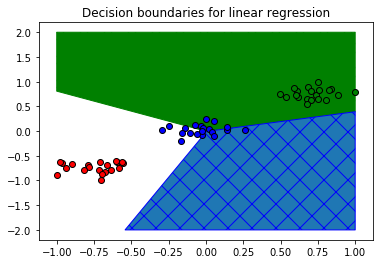

The test accuracy of logistic regression is: 1.0


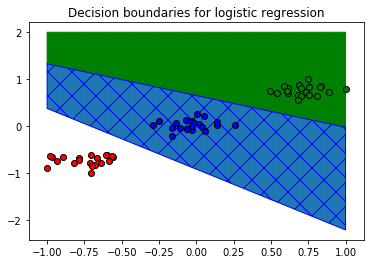

In [52]:
imp.reload(hw5)
dataC = loadmat('partC_three_linear.mat')
linC = hw4.linReg()
linC.loadData(dataC, list(dataC.keys())[3:7])
linC.fit()
linC.makePhi()
yHat = np.argmax(linC.phiTest.dot(linC.w), axis=1)
y = np.argmax(linC.yTest, axis=1)
print('The test accuracy of linear regression is:', np.sum(y == yHat) / len(y))

plt.title('Decision boundaries for linear regression')
hw5.plotDecision(linC.w, linC.xTest, linC.yTest)

logC = hw5.logisticRegression(k=3, scale = False)
logC.loadData(dataC, list(dataC.keys())[3:7])
logC.makeFeatures()
logC.fit(0.00000001)
w = np.reshape(logC.w, (3, 3))
yHat = np.argmax(logC.xTest.dot(w.transpose()), axis=1)
y = np.argmax(logC.yTest,axis=1)
print('The test accuracy of logistic regression is:', np.sum(y == yHat) / len(y))

plt.title('Decision boundaries for logistic regression')
hw5.plotDecision(w.transpose(), logC.xTest[:, 1:3], logC.yTest)